This notebook runs scripts that implement transfer learning and random search. 

In [1]:
import pandas as pd
from itertools import cycle, islice
import seaborn 
% pylab inline

Populating the interactive namespace from numpy and matplotlib


## Transfer Learning Results

**my-best-single-model-simple-cnn-lb-0-1541.py** is a Kernel from Kaggle modified to apply the AutoAugment Policies to the Iceberg Classification Challenge. We apply the CIFAR-10 and SVHN policies and show that both policies improve over the baseline kernel.  

In [2]:
! cd ../transfer_learning/iceberg; python my-best-single-model-simple-cnn-lb-0-1541.py

Traceback (most recent call last):
  File "my-best-single-model-simple-cnn-lb-0-1541.py", line 4, in <module>
    import cv2 # Used to manipulated the images 
ImportError: No module named cv2


The results are written to final_ensemble.csv

In [3]:
iceberg_results = pd.read_csv('../transfer_learning/iceberg/final_ensemble.csv')
print iceberg_results.shape

The final_ensemble.csv contains probabilties for each image in the test set. 'id' is the ID of each image and 'is_iceberg' is the probabilty of that image being an iceberg. Submitting this file with predictions to Kaggle returns the log loss which is being reported here. 

In [5]:
iceberg_results.head()

,id,is_iceberg
0,5941774d,0.068249
1,4023181e,0.532265
2,b20200e4,0.000221
3,e7f018bb,0.996528
4,4371c8c3,0.026611


The chart below shows the comparison between the baseline model (with no augmentation), model with CIFAR-10 augmentations and model with SVHN augmentations. 

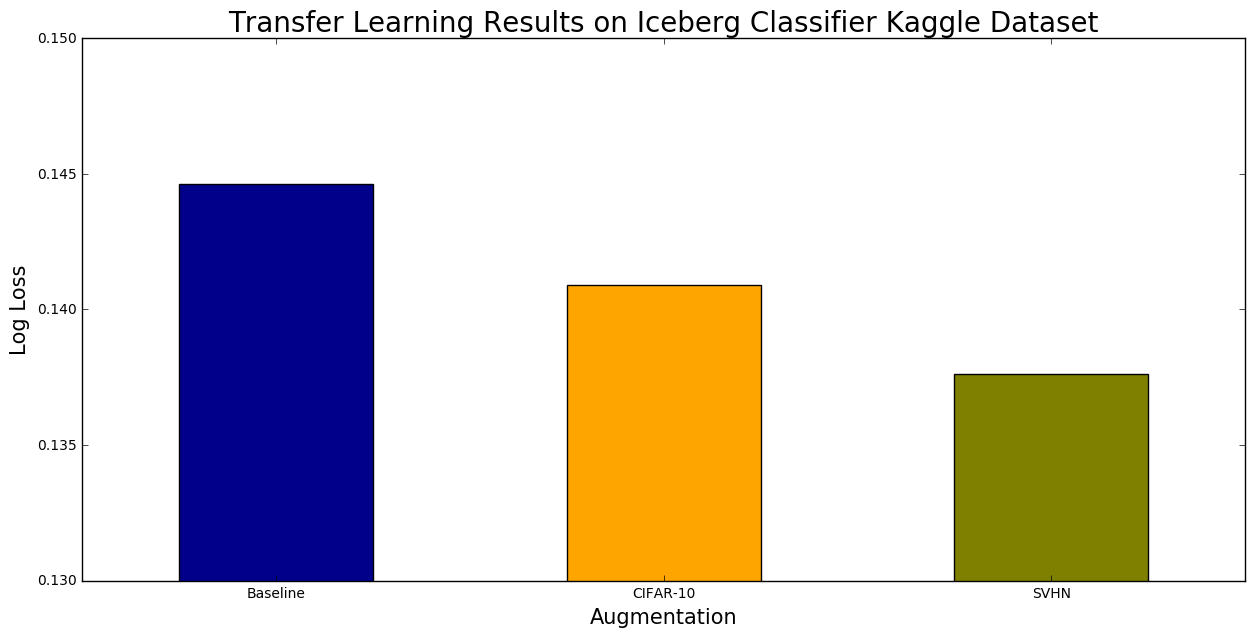

In [6]:
results_df = pd.DataFrame({'model':['Baseline', 'CIFAR-10', 'SVHN'], \
                           'log_loss':[0.1446,0.1409, 0.1376]})

my_colors = list(islice(cycle(['darkblue', 'orange', 'olive']), None, len(results_df)))
results_df.plot.bar(x='model', y='log_loss', rot=0,\
                    color=my_colors, legend=None)

plt.title('Transfer Learning Results on Iceberg Classifier Kaggle Dataset', size = 20)
plt.ylabel('Log Loss', size = 15)
plt.xlabel('Augmentation', size = 15)
plt.ylim(0.13 , 0.15)
plt.gcf().set_size_inches(15,7)

--- 

## Simplified AutoAugment Results

This strategy was inspired by random grid search for hyperparameter tuning.
The ”Random Search Controller” was run for 250 epochs and kept track of the best policies it found for CIFAR-10. The policy that produced the best results was as follows:

- Sub-Policy 0 = (Brightness, 0.1, 1.9), (ShearX, 0.0, - 0.3)
- Sub-Policy 1 = (Invert, 0.7, 0.111), (Contrast, 0.5, 1.5)
- Sub-Policy 2 = (Invert, 0.3, 0.667), (Color, 0.5, 1.7)]
- Sub-Policy 4 = (Rotate, 1.0, 0.778), (ShearY, 0.3, - 0.45)
- Sub-Policy 5 = (Brightness, 0.1, 1.5), (Invert, 0.9, 0.889)

In [ ]:
! cd ../autoaugment_performance/random_search/run.py

The results of the run.py are written to log.txt


Logfile contains information about subpolicies used for each epoch. After each epoch, child accuracy is printed.

In [42]:
! head -18 "../random_search/log.txt"


Controller: Epoch 1 / 250
# Sub-policy 1
Operation  2 (P=0.900, M=0.450)
Operation  7 (P=1.000, M=0.778)
# Sub-policy 2
Operation  9 (P=0.100, M=7.111)
Operation 14 (P=0.800, M=0.089)
# Sub-policy 3
Operation  5 (P=0.700, M=0.556)
Operation 12 (P=0.000, M=1.500)
# Sub-policy 4
Operation  0 (P=0.100, M=0.300)
Operation  3 (P=0.400, M=-0.150)
# Sub-policy 5
Operation 12 (P=0.200, M=0.300)
Operation 14 (P=0.700, M=0.089)
-> Child accuracy: 0.419 (elaspsed time: 102s)


The chart below shows the comparison between the baseline model (with no augmentation), model with Random Search AutoAugment (simplified) top 5 subpolicies augmentations, and model with original Reinforcement Learning AutoAugment augmentations.

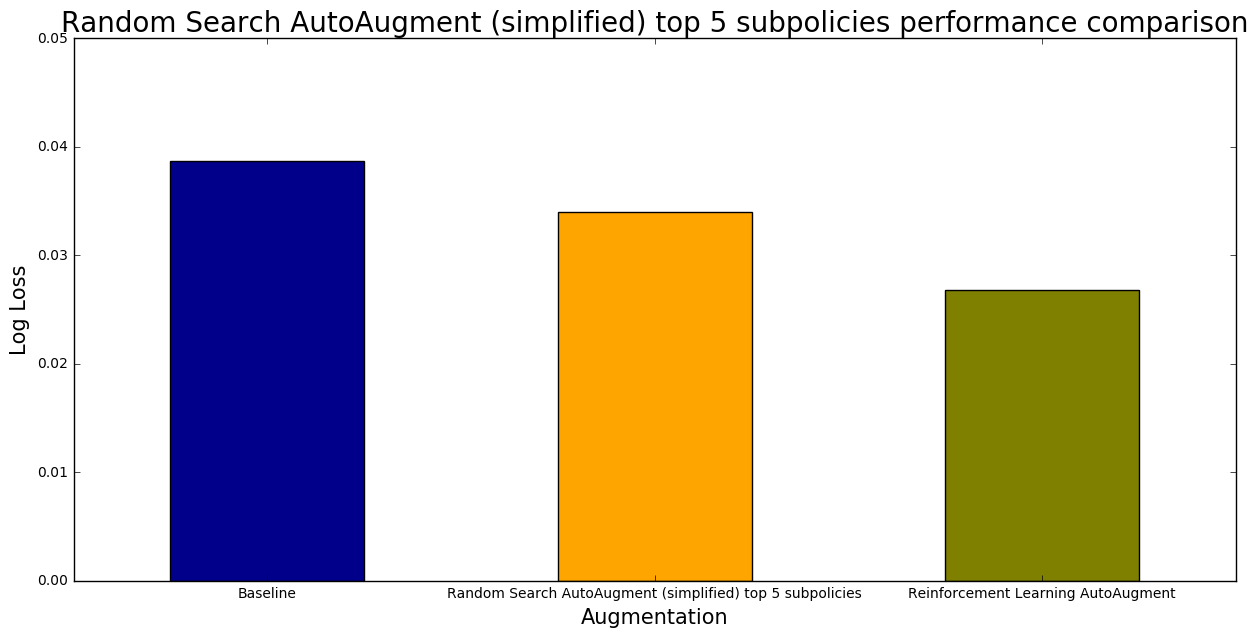

In [13]:
random_search_results_df = pd.DataFrame({'model':['Baseline', \
                                                  'Random Search AutoAugment (simplified) top 5 subpolicies', \
                                                  'Reinforcement Learning AutoAugment'],\
                           'log_loss':[0.0387,0.034, 0.0268]})

my_colors = list(islice(cycle(['darkblue', 'orange', 'olive']), None, len(results_df)))
random_search_results_df.plot.bar(x='model', y='log_loss', rot=0,\
                    color=my_colors, legend=None)

plt.title('Random Search AutoAugment (simplified) top 5 subpolicies performance comparison', size = 20)
plt.ylabel('Log Loss', size = 15)
plt.xlabel('Augmentation', size = 15)
plt.ylim(0 , 0.05)
plt.gcf().set_size_inches(15,7)